In [1]:
from scipy.stats import poisson,norm
from math import log
#from scipy.integrate import simpson
from scipy.optimize import minimize
from functools import partial
from scipy.integrate import quad
import numpy as np
from matplotlib import pyplot as plt
#from scipy.integrate import cumulative_trapezoid
from scipy.stats import chi2
np.random.seed(3553)

In [2]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('legend',fontsize=15)
plt.rc('font',size=15)

In [3]:
def model_poisson(n,s,b):
    return poisson(s+b).pmf(n)

def model_poisson_2d(n,x):
    s = x[0]
    b = x[1]
    return model_poisson(n,s,b)

def constraint_b(b,bmu,sigmab):
    return norm(loc=bmu,scale=sigmab).pdf(b)

def model_constraint_freq(n,s,b,bbar,sigmab):
    return model_poisson(n,s,b)*constraint_b(bbar,b,sigmab)

def generate_data(s, b, sigmab):
    n1 = np.random.randint(s+b-1.5*np.sqrt(s+b), s+b+1.5*np.sqrt(s+b), 1000000) #cambia i limiti a seconda di caso i o ii
    bbar1 = np.random.uniform(b-1.5*sigmab, b+1.5*sigmab, 1000000)
    y = model_constraint_freq(n1, s, b, bbar1, sigmab)
    y1 = np.random.uniform(0, np.max(y), 1000000)
    return n1[y1 <= y][:ndata], bbar1[y1 <= y][:ndata] #accept-reject

def model_constraint_2d_freq(n,x,bbar,sigmab):
    s = x[0]
    b = x[1]
    return model_constraint_freq(n,s,b,bbar,sigmab)

def nll(model,n,s,b,**kwargs):
    return -np.log(model(n,s,b,**kwargs))

def nll_2d(model,n,x,**kwargs):
    return -np.log(model(n=n,x=x,**kwargs))

def testStatistic(model,n,s,b,bestNLL,**kwargs):
    return 2*(nll(model=model,n=n,s=s,b=b,**kwargs)-bestNLL)

In [4]:
#Case i)
s = 50
b = 150
sigmab = 30

In [7]:
#Case ii)
s = 5
b = 15
sigmab = 9.5

In [5]:
ndata = 10
experiment = generate_data(s, b, sigmab)
experiment

(array([195, 204, 213, 206, 184, 182, 189, 179, 203, 181]),
 array([126.72318651, 171.18006142, 166.32569975, 115.17444736,
        164.53621184, 128.88661761, 160.3539388 , 139.6757694 ,
        142.49769963, 140.05476887]))

In [14]:
### Questa cella richiede un po' di tempo per essere eseguita
ndata = 1000
experiment = generate_data(s, b, sigmab)

limit = chi2(1).ppf(0.90) # 95% one sided CL
ok_upper_limit = 0

for i in range (ndata):

    n = experiment[0][i]
    bbar = experiment[1][i]
    
    #res.x[0] è il segnale, res.x[1] il bkg
    res = minimize(partial(nll_2d,model_constraint_2d_freq,n,bbar=bbar,sigmab=sigmab),x0=(s,b),bounds=[(0,np.inf),(0,np.inf),])
    bestNLL = res.fun
    t = np.array([])
    
    sig = np.linspace(res.x[0]-10, res.x[0]+40, 500)
    
    print('sbest = %.2f'%(res.x[0]))
    for si in sig:
        res = minimize(partial(nll,model_constraint_freq,n,si,bbar=bbar,sigmab=sigmab),x0=(b,),bounds=[(0,np.inf),])
        t = np.append(t,testStatistic(model=model_constraint_freq,n=n,s=si,b=res.x[0],bestNLL=bestNLL,bbar=bbar,sigmab=sigmab))
        
    #plt.plot(sig,t,label='Profiled likelihood ratio',lw=1)
    idx = (t>limit).argmax()
    if(idx != 0):
        upper_limit = 0.5*(sig[idx]+sig[idx-1])
    else:
        upper_limit = sig[idx]
    print('sigmab = %.2f, n = %.2f, bbar = %.2f, limit = %.2f, upper limit on s = %.2f'%(sigmab, n, bbar, limit, upper_limit))

    #Scrivo su file quanto ottengo -> cambia nome al file nel caso i e ii
    file = open("UpperLimit_ii.txt", "a")
    file.write(str(upper_limit) + "\n")
    file.close()

    if(upper_limit >= s):
        ok_upper_limit = ok_upper_limit + 1
        
#plt.vlines(upper_limit,0,limit,lw=1,color='r',label=r'$s_{up} = $ %.2f'%(upper_limit) + ' 95% C.L. one-sided')
#plt.xlabel('s',fontsize=15)
#plt.ylabel('t',fontsize=15)
#plt.axhline(limit,color='black',lw=1, label = r'$\chi^2$ 1 ndof quantile for 95% C.L. one-sided')
#plt.legend(loc='best')
#plt.grid()

sbest = 12.32
sigmab = 9.50, n = 16.00, bbar = 3.68, limit = 2.71, upper limit on s = 23.32
sbest = 4.71
sigmab = 9.50, n = 24.00, bbar = 19.29, limit = 2.71, upper limit on s = 22.51
sbest = 8.35
sigmab = 9.50, n = 19.00, bbar = 10.65, limit = 2.71, upper limit on s = 24.75
sbest = 5.13
sigmab = 9.50, n = 21.00, bbar = 15.87, limit = 2.71, upper limit on s = 22.64
sbest = 0.00
sigmab = 9.50, n = 20.00, bbar = 24.34, limit = 2.71, upper limit on s = 13.70
sbest = 10.88
sigmab = 9.50, n = 13.00, bbar = 2.12, limit = 2.71, upper limit on s = 19.77
sbest = 10.10
sigmab = 9.50, n = 22.00, bbar = 11.90, limit = 2.71, upper limit on s = 27.40
sbest = 13.80
sigmab = 9.50, n = 22.00, bbar = 8.20, limit = 2.71, upper limit on s = 29.20
sbest = 1.28
sigmab = 9.50, n = 25.00, bbar = 23.72, limit = 2.71, upper limit on s = 19.18
sbest = 6.72
sigmab = 9.50, n = 25.00, bbar = 18.28, limit = 2.71, upper limit on s = 24.63
sbest = 4.65
sigmab = 9.50, n = 20.00, bbar = 15.35, limit = 2.71, upper limit 

KeyboardInterrupt: 

In [23]:
#Case i)
s = 50
b = 150
sigmab = 30

In [24]:
sup = np.array([])
f = open("UpperLimit_i.txt", "r")
for line in f.readlines():
    sup = np.append(sup, float(line))
f.close()

coverage = len(sup[sup>s])/len(sup)
coverage

0.9489878542510122

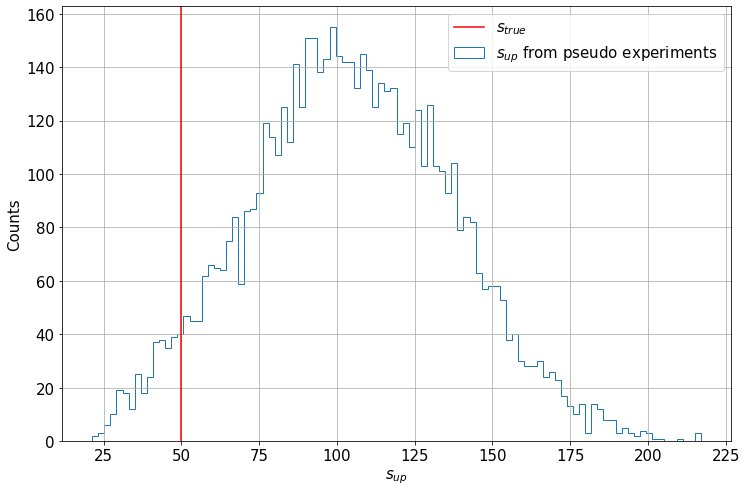

In [25]:
dataf, bins,_ = plt.hist(sup,bins=100,histtype='step',label=r'$s_{up}$ from pseudo experiments')
plt.xlabel(r'$s_{up}$')
plt.ylabel('Counts')
plt.grid(True)
plt.axvline(s,color='red',label='$s_{true}$')
plt.legend(loc='best')
plt.savefig("Supi.png", bbox_inches='tight')

In [16]:
#Case ii)
s = 5
b = 15
sigmab = 9.5

In [22]:
sup = np.array([])
f = open("UpperLimit_ii.txt", "r")
for line in f.readlines():
    sup = np.append(sup, float(line))
f.close()

coverage = len(sup[sup>s])/len(sup)
coverage

0.9996761133603239

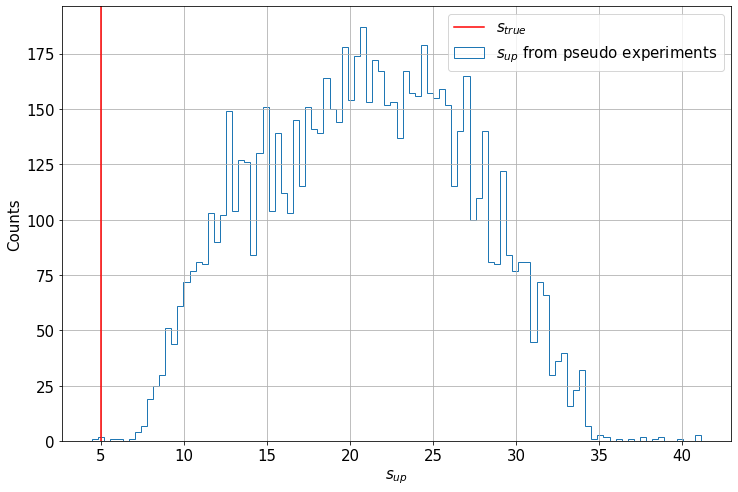

In [21]:
dataf, bins,_ = plt.hist(sup,bins=100,histtype='step',label=r'$s_{up}$ from pseudo experiments')
plt.xlabel(r'$s_{up}$')
plt.ylabel('Counts')
plt.grid(True)
plt.axvline(s,color='red',label='$s_{true}$')
plt.legend(loc='best')
plt.savefig("Supii.png", bbox_inches='tight')